Reference: https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2


In [1]:
#build a topic model using Gensim LDA and visualise the topics using pyLDAvis and create a word cloud for each topic

import re
import pandas as pd
import numpy as np
import os
import pprint

#Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['irish'])

import spacy

import pyLDAvis 
import pyLDAvis.gensim_models

import seaborn as sns 
sns.set()

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)





/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
#load in the data 
df = pd.read_csv('irish_kwics_with_50_word_window.csv')
#convert key words in context into list of strings
data = list(df.kwic)


Build the bigram and trigrams

In [3]:
# Build the bigram and trigrams
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

define a function for preprocessing:

In [4]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [5]:
# call the function, The output of data_ready is a list containing list of strings for each document 
data_ready = process_words(data)

Create the Dictionary and Corpus:
The model requires a dictionary and a corpus to process. Dictionary contains all the words and numerical identifiers one for each unique word. On the other hand, corpus is a list of lists containing tuples for each word id and its frequency.

In [6]:
#create dictionary and get the length of vocabulary:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 47368


In [7]:
#create corpus:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [8]:
#create a dictionary to display word frequency
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/var/folders/v8/16yc7hy13dn8gqzv70qdbg1h0000gn/T/ipykernel_86557/3355411391.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dict_df['freq'], bins=100);


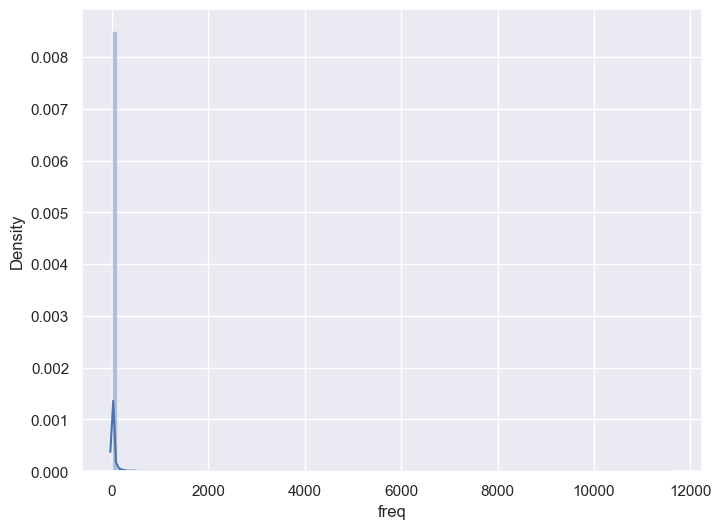

In [9]:
#make a histogram that shows word frequencies to better understand the corpus
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [10]:
#display top 10 most frequent words
dict_df.sort_values(by='freq', ascending=False).head(10)


,freq
irish,11632
say,4881
man,2902
know,2335
come,2197
make,2057
see,1910
look,1796
take,1740
well,1684


Exclude high frequency words from dictionary. Threshold established at 2000 occurances.

In [11]:
extension = dict_df[dict_df.freq>2000].index.tolist()

In [12]:
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 47547


Filter out words that occur less than 10 documents, or more than 70% of the documents.

In [13]:

id2word.filter_extremes(no_below=10, no_above=0.7) #change no_above to change threshold
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 4784


In [14]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [15]:
#install the mallett package
#!python -m wget https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip





In [16]:
#!unzip mallet-2.0.8.zip

In [17]:
import os

In [18]:
#get the file path to the mallet package 
current_file_path = os.path.abspath(os.path.dirname('__file__'))
mallet_path = os.path.join(current_file_path, 'mallet-2.0.8', 'bin', 'mallet')




In [19]:
from gensim.models.wrappers import LdaMallet


specify the number of topics in advance.

In [20]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57
total tokens: 254462
<10> LL/token: -9.60599
<20> LL/token: -9.2099
<30> LL/token: -8.94424
<40> LL/token: -8.74934

0	5	girl eye face woman young black hair love head draw blue child white tall stand heart lovely room bright beautiful 
1	5	question speak tbe fact word show land british law understand matter chapter english country aud people government home throw continue 
2	5	dear mind hear give people great pay family blood fellow time young story ireland land lady chapter idea carry number 
3	5	turn talk close hold young hand word part send fancy short rest war light exclaim write foot door feel smile 
4	5	good woman fall begin town bad lie turn reply case run enter leave ill low stand dress round hand room 
5	5	voice hand eye pretty call song sing wear answer mother dark back side sweet long air hear speak door rise 
6	5	break horse thing back fight force fire body business form moment charge full nat

In [21]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('eye', 0.05139686184462304),
   ('face', 0.03134328358208955),
   ('head', 0.015996938384998088),
   ('girl', 0.01580558744737849),
   ('hand', 0.014619211634137007),
   ('woman', 0.013432835820895522),
   ('long', 0.013279755070799848),
   ('black', 0.013050133945656333),
   ('dark', 0.011863758132414848),
   ('hair', 0.011213164944508228)]),
 (1,
  [('country', 0.0234078127374981),
   ('people', 0.01896184830521356),
   ('tbe', 0.016377868977048182),
   ('question', 0.015845873233014136),
   ('land', 0.015503875968992248),
   ('english', 0.012121903024775801),
   ('great', 0.009157926736586107),
   ('member', 0.008777929776561787),
   ('party', 0.008739930080559356),
   ('british', 0.008169934640522876)]),
 (2,
  [('people', 0.02144037399750131),
   ('continue', 0.02079555071938097),
   ('chapter', 0.020392536170555756),
   ('great', 0.019425301253375247),
   ('call', 0.019022286704550036),
   ('mind', 0.011727723370813686),
   ('pay', 0.010438076814573006),
   ('idea', 0.01

In [22]:
#save the model as a pickle file to load in later for analysis
import pickle
pickle.dump(ldamallet, open('ldamallet_irish_10_topics.pkl', 'wb'))

In [23]:
#load the model
ldamallet = pickle.load(open('ldamallet_irish_10_topics.pkl', 'rb'))


get the topic modeling results (distribution of topics for each document) by passing in the corpus to the model.

In [24]:
tm_results = ldamallet[corpus]

In [25]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

To get most probable words for the given topicid, we can use show_topic() method. It returns sequence of probable words, as a list of (word, word_probability) for specific topic. You can get top 20 significant terms and their probabilities for each topic as below:

In [26]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

display all the terms for a topic in a single row

In [28]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/var/folders/v8/16yc7hy13dn8gqzv70qdbg1h0000gn/T/ipykernel_86557/957036083.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"eye, face, head, girl, hand, woman, long, black, dark, hair, beautiful, light, smile, blue, stand, fine, wear, white, fair, big"
Topic2,"country, people, tbe, question, land, english, great, member, party, british, law, state, ireland, government, power, hold, feeling, church, vote, free"
Topic3,"people, continue, chapter, great, call, mind, pay, idea, carry, doubt, true, tion, character, irishman, fact, death, interest, aid, blood, common"
Topic4,"good, thing, laugh, talk, put, part, word, half, long, feel, set, rest, play, remember, read, lady, blood, understand, kind, lay"
Topic5,"lie, woman, friend, good, work, cry, hand, reply, draw, tho, ill, arm, sho, bad, sir, dead, bit, captain, enter, run"
Topic6,"hear, speak, turn, room, dear, voice, answer, door, sit, boy, word, open, call, hand, moment, song, evening, hold, ing, sing"
Topic7,"order, send, fall, side, stand, horse, break, fire, moment, officer, french, soldier, great, ground, general, fight, force, move, king, back"
Topic8,"time, give, day, leave, find, return, bad, follow, meet, present, lose, hope, matter, place, begin, feel, fear, end, add, remark"
Topic9,"pass, find, bring, place, house, night, morning, hour, home, wild, high, letter, town, water, grow, day, story, show, small, sea"
Topic10,"young, year, girl, heart, love, mother, life, live, child, poor, lady, die, father, family, wife, world, miss, marry, money, bear"


Visualize the terms as wordclouds is also a good option to present topics. Below we create wordclouds for each topic. The font sizes of words show their relative weights in the topic.

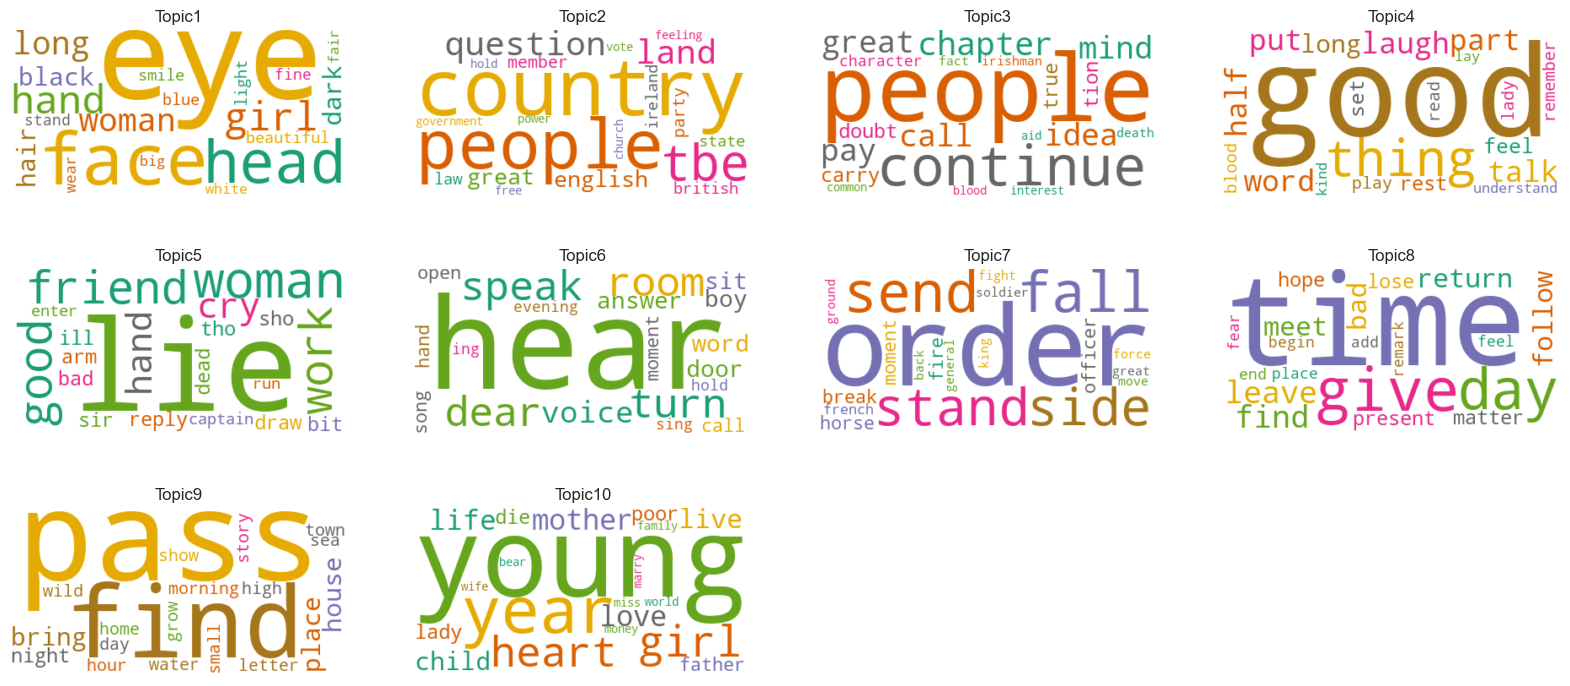

In [29]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [30]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [31]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [33]:
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

create a dataframe that shows dominant topic for each document and its percentage in the document.

In [39]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['Trove_ID'] = df.trove_id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,Trove_ID,Dominant Topic,Contribution %,Topic Terms
0,3,3,15.10,"people, continue, chapter, great, call, mind, pay, idea, carry, doubt, true, tion, character, irishman, fact, death, interest, aid, blood, common"
1,4,9,17.81,"pass, find, bring, place, house, night, morning, hour, home, wild, high, letter, town, water, grow, day, story, show, small, sea"
2,8,10,13.89,"young, year, girl, heart, love, mother, life, live, child, poor, lady, die, father, family, wife, world, miss, marry, money, bear"
3,9,1,15.30,"eye, face, head, girl, hand, woman, long, black, dark, hair, beautiful, light, smile, blue, stand, fine, wear, white, fair, big"
4,9,6,17.17,"hear, speak, turn, room, dear, voice, answer, door, sit, boy, word, open, call, hand, moment, song, evening, hold, ing, sing"


In [41]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)
#write to csv file 'Topic_in_Doc_Irish_KWIC_10_Topics.csv'
corpus_topic_df.to_csv('Topic_in_Doc_Irish_KWIC_10_Topics.csv', index=False)
